# 项目 : 创建客户分类

## 加载数据
这个项目的数据集能够在[UCI机器学习信息库](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)中找到.因为这个项目的目的，分析将不会包括 'Channel' 和 'Region' 这两个特征——重点集中在6个记录的客户购买的产品类别上。

In [1]:
# 检查你的Python版本
from sys import version_info
if version_info.major != 3:
    raise Exception('请使用Python 3.x 来完成此项目')
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 引入这个项目需要的库
import numpy as np
import pandas as pd
import visuals as vs
from IPython.display import display # 使得我们可以对DataFrame使用display()函数
# 设置以内联的形式显示matplotlib绘制的图片（在notebook中显示更美观）
%matplotlib inline
# 高分辨率显示
# %config InlineBackend.figure_format='retina'

# 载入整个客户数据集
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("数据加载成功 有 {} 条数据 {}个特征每条数据.".format(*data.shape))
except:
    print("数据加载失败")

数据加载成功 有 440 条数据 6个特征每条数据.


## 分析数据
在这部分，将开始分析数据，通过可视化和代码来理解每一个特征和其他特征的联系。将会看到关于数据集的统计描述，考虑每一个属性的相关性，然后从数据集中选择若干个样本数据点，在整个项目中一直跟踪研究这几个数据点。

这个数据集包含了6个重要的产品类型：**'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**和 **'Delicatessen'**。想一下这里每一个类型代表你会购买什么样的产品。

In [3]:
# 显示数据集的一个描述
display(data.describe())

np.percentile(data, 90, axis = 0)

Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper  Delicatessen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%         3922.000000   1820.250000  
max        40827.000000  47943.000000

array([27090.5, 12229.9, 18910.1,  7545.3,  7438.3,  2945.9])

In [4]:
data[(data.Milk>=12000) & (data.Detergents_Paper >= 7438) &(data.Grocery >= 18910)] #咖啡馆
data[(data.Fresh>=20000) & (data.Delicatessen >= 3000)]#饭店
data[(data.Fresh<10000)&(data.Delicatessen >= 3000)&(data.Grocery >= 18910)&(data.Frozen>=3000)]#超市

Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
92    9198  27472    32034    3232             18906          5130
251   6134  23133    33586    6746             18594          5121

###  选择样本

不断尝试，尽量找找到三个明显不同的客户

In [5]:
# 从数据集中选择三个你希望抽样的数据点的索引
indices = [65,87,251]

# 为选择的样本建立一个DataFrame
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples) #percentile

Chosen samples of wholesale customers dataset:


Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0     85  20959    45828      36             24231          1423
1  43265   5025     8117    6312              1579         14351
2   6134  23133    33586    6746             18594          5121

### 问题 1
在你看来你选择的这三个样本点分别代表什么类型的企业（客户）？对每一个你选择的样本客户，通过它在每一种产品类型上的花费与数据集的统计描述进行比较，给出你做上述判断的理由。

**回答:**
* 1:首先第一条记录，很大可能是咖啡馆，因为它的Milk和Grocery，还有Detergents_Paper都远大与均值，用百分比函数percentile统计，90%以上都低于第一条记录的这几个值，而它的fresh和frozen非常低，Delicatessen也低于均值。
* 2:第二条记录还大可能是饭店，因为它的Fresh和Delicatessen，用百分比函数percentile统计，90%低于它们，Frozen也比均值大很多，所以是饭店的可能性非常大
* 3:第三条记录我推断很大可能是大型超市，除了fresh，其他数值均远高于均值，甚至有的超过90%的记录，而超市主要存储大量长期可保存产品较为便利，所以在fresh，不会保留很多，这符合常识

###  特征相关性

一个有趣的想法是，考虑这六个类别中的一个（或者多个）产品类别，是否对于理解客户的购买行为具有实际的相关性。也就是说，当用户购买了一定数量的某一类产品，我们是否能够确定他们必然会成比例地购买另一种类的产品。有一个简单的方法可以检测相关性：我们用移除了某一个特征之后的数据集来构建一个监督学习（回归）模型，然后用这个模型去预测那个被移除的特征，再对这个预测结果进行评分，看看预测结果如何。这里我移除`Grocery`这个特征

In [6]:
# 为DataFrame创建一个副本，用'drop'函数丢弃一个特征
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
new_data = data.drop('Grocery',axis = 1)
y_data = data['Grocery']

# 使用给定的特征作为目标，将数据分割成训练集和测试集
X_train, X_test, y_train, y_test =  train_test_split(new_data, y_data, test_size=0.25, random_state=42)

# 创建一个DecisionTreeRegressor（决策树回归器）并在训练集上训练它
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train,y_train)
# 输出在测试集上的预测得分
score = regressor.score(X_test, y_test)
print(score)
from sklearn.metrics import r2_score
y_pred = regressor.predict(X_test)
score = r2_score(y_test,y_pred)
print (score)

0.6818840085440834
0.6818840085440834


从得分情况可以看出 ，得分最高的是'Grocery',得分为0.68，这个值比较高，因此这个'Grocery'特征是不必要的，因为从score得分来看，可以用其它特征预测出这个特征来，表明这个'Grocery'特征与其它特征具有一定相关性

### 可视化特征分布
为了能够对这个数据集有一个更好的理解，我们可以对数据集中的每一个产品特征构建一个散布矩阵（scatter matrix）。如果你发现你在上面尝试预测的特征对于区分一个特定的用户来说是必须的，那么这个特征和其它的特征可能不会在下面的散射矩阵中显示任何关系。相反的，如果你认为这个特征对于识别一个特定的客户是没有作用的，那么通过散布矩阵可以看出在这个数据特征和其它特征中有关联性。

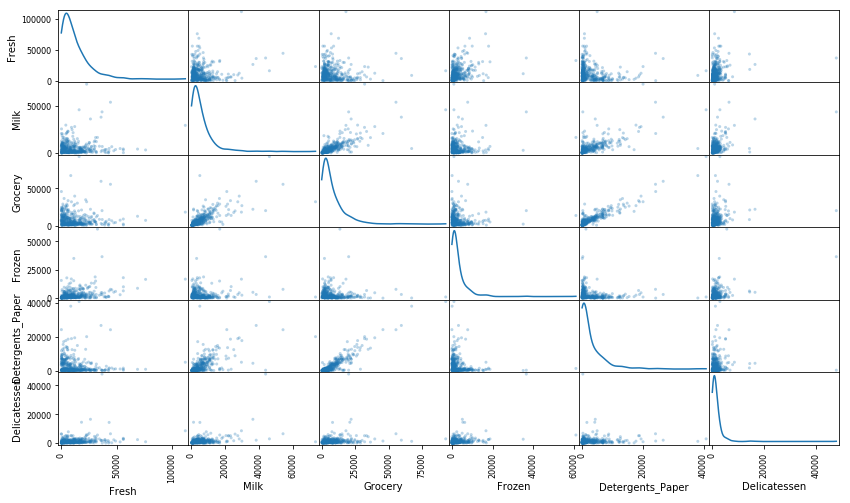

In [7]:
# 对于数据中的每一对特征构造一个散布矩阵
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [ ]:
#相关系数
corrmat = data.corr().abs()
display(corrmat)

In [ ]:
import seaborn as sns
#绘制特征属性相关属性的
sns.heatmap(data.corr(), annot=True)